In [1]:
%matplotlib inline

In [ ]:
%autoreload 2

In [2]:
import os
import numpy as np
from numpy.random import RandomState
from matplotlib import pyplot as plt
from matplotlib.pyplot import *
from time import time
#import updates
import theano
import theano.tensor as T
from scipy.stats import gaussian_kde
from scipy.misc import imsave, imread


In [3]:
from GAN_module import *

In [4]:
# ------------------------------------------------------ Define hyperparameters ------------------------------------------------------------
leakyrectify = LeakyRectify()
rectify = Rectify()
tanh = Tanh()
sigmoid = Sigmoid()
bce = T.nnet.binary_crossentropy
batch_size = 128
nh = 2048



In [5]:

# ---------------------------------------------- Build Generator and Discriminator Network -------------------------------------------------
def g(X, w, w2, wo):
    h = leakyrectify(T.dot(X, w))      # (-inf ; inf)
    h2 = leakyrectify(T.dot(h, w2))    # (-inf ; inf)
    y = T.dot(h2, wo)                  # (-inf ; inf)
    return y

def d(X, w, w2, wo):
    h = rectify(T.dot(X, w))           # (0 ; inf)
    h2 = tanh(T.dot(h, w2))            # (-1 ; 1)
    y = sigmoid(T.dot(h2, wo))         # (0 ; 1)
    return y


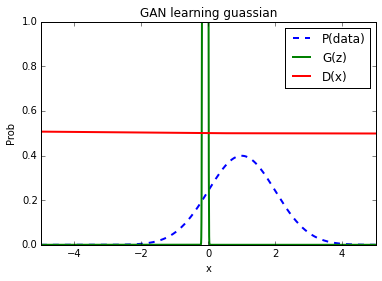

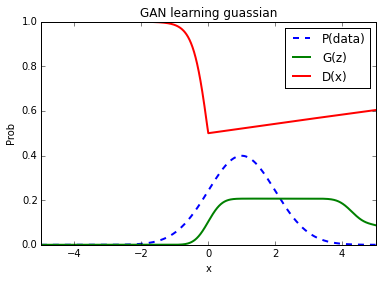

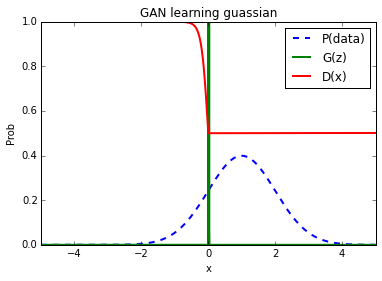

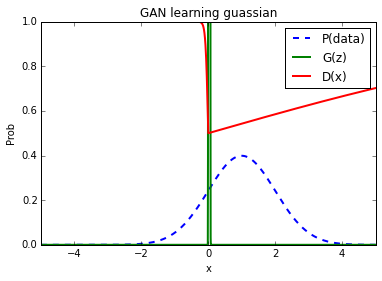

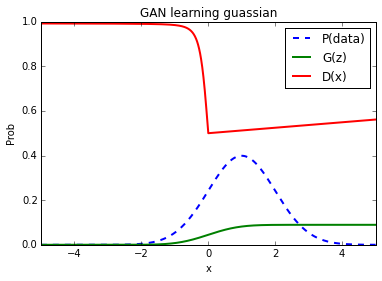

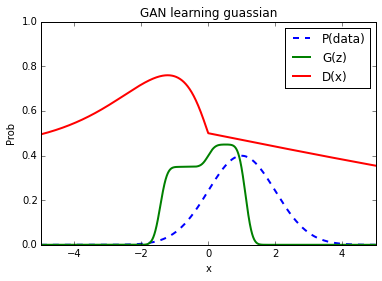

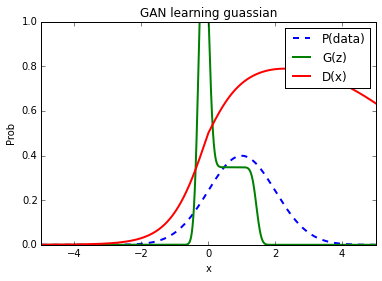

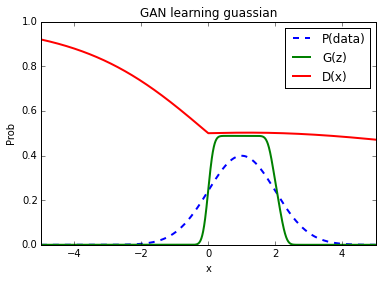

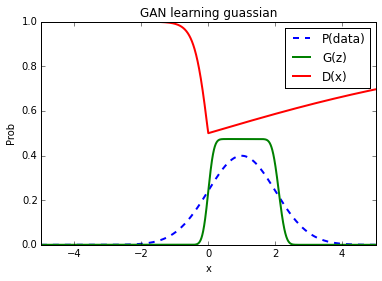

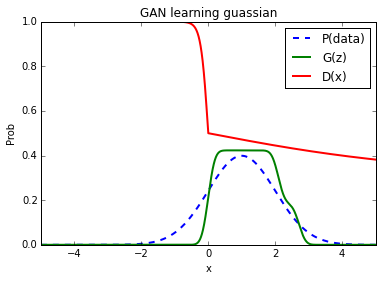

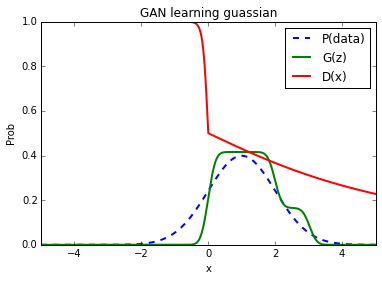

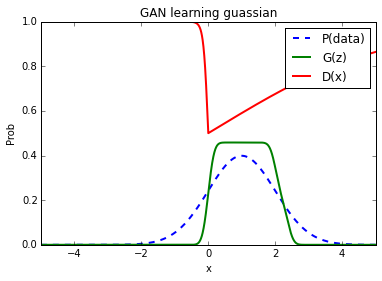

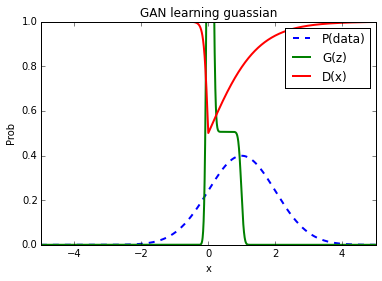

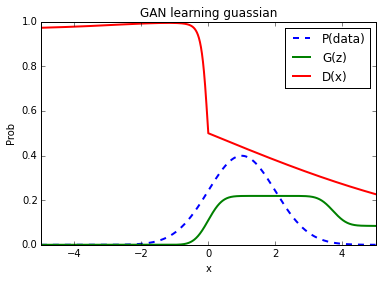

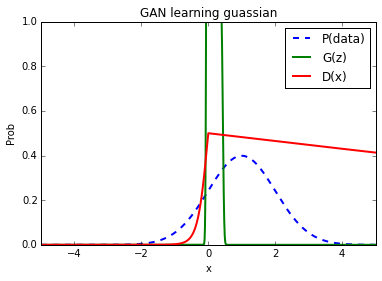

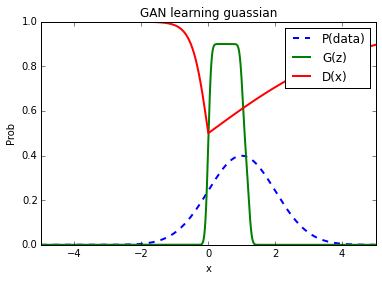

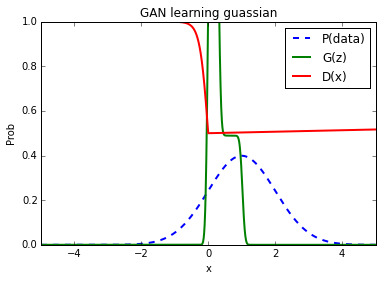

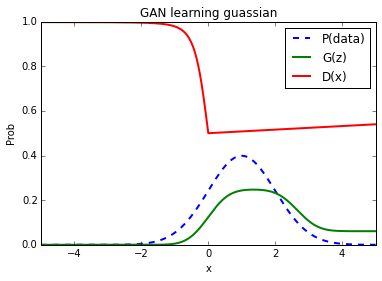

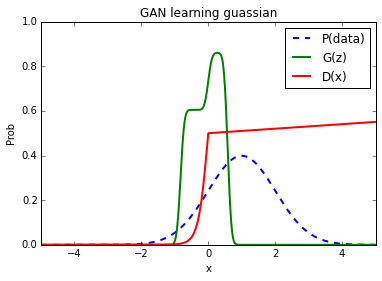

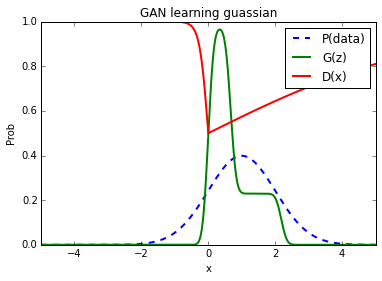

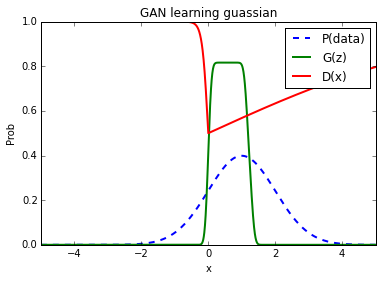

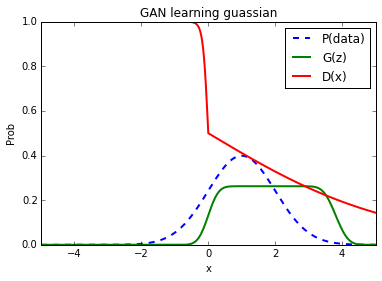

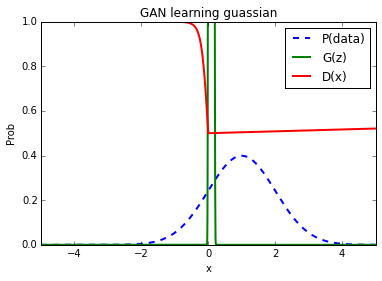

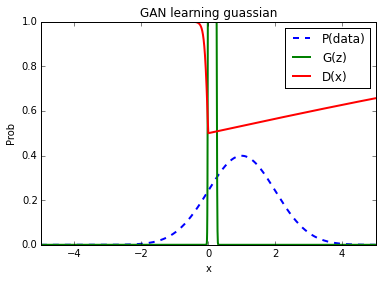

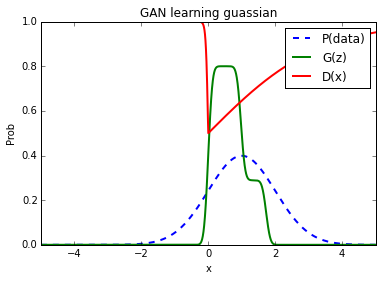

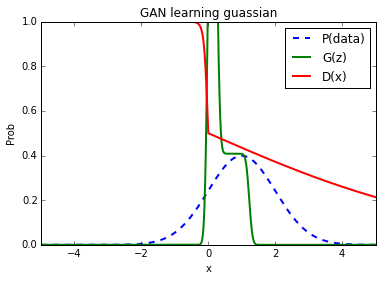

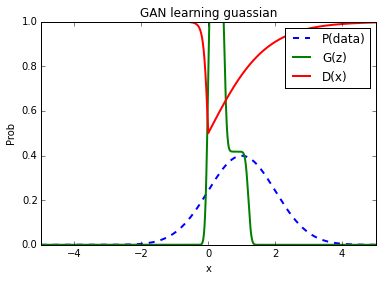

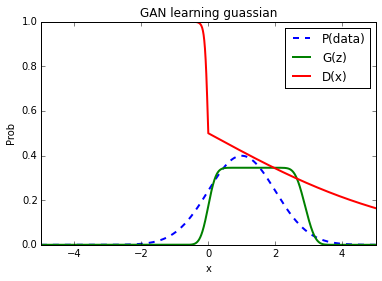

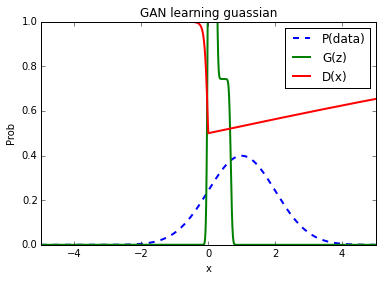

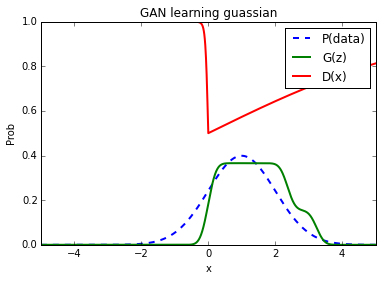

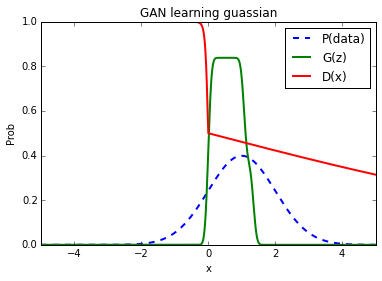

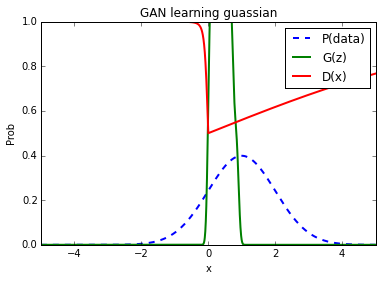

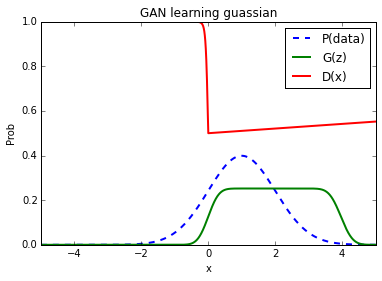

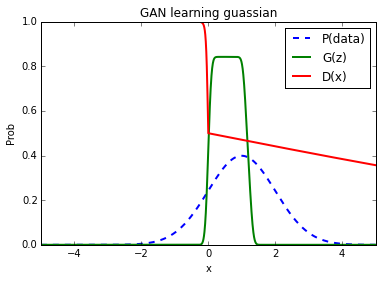

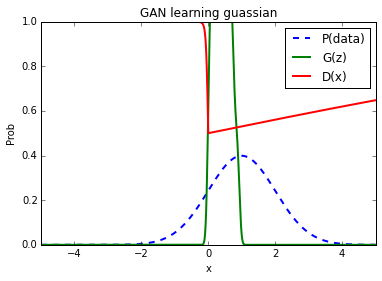

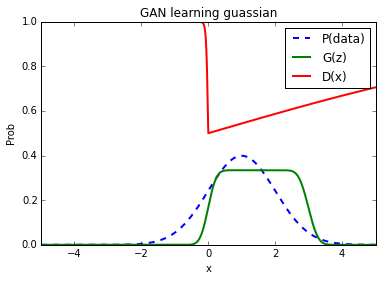

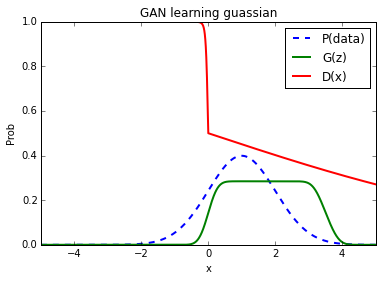

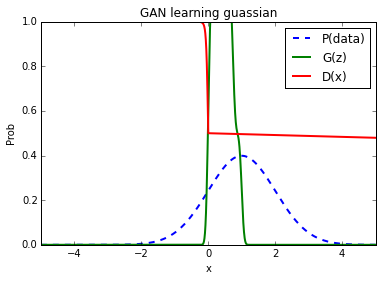

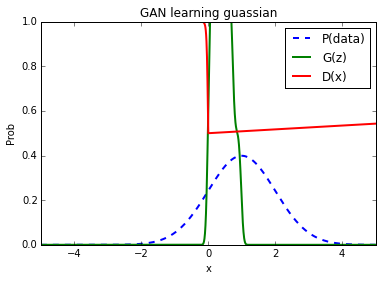

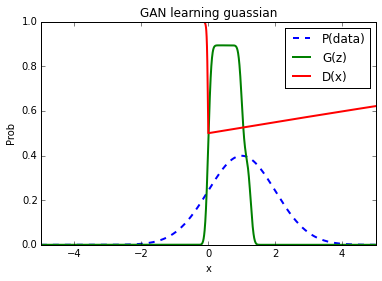

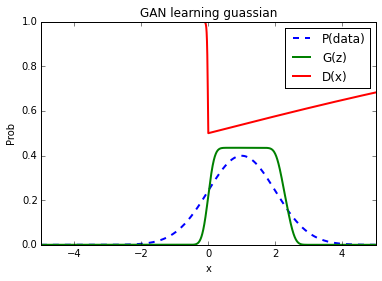

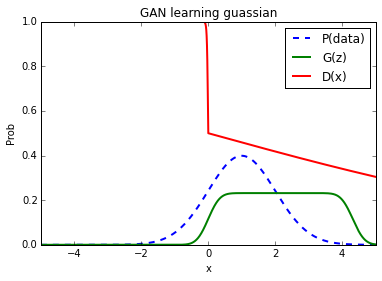

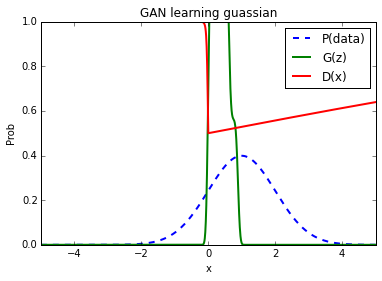

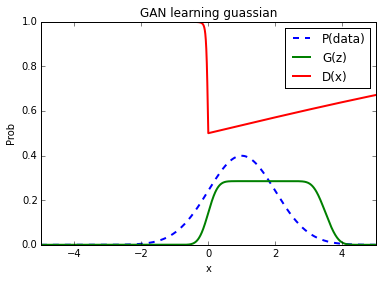

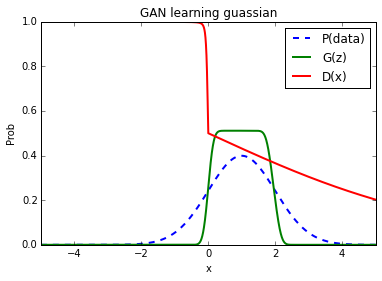

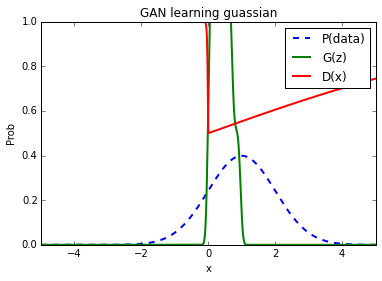

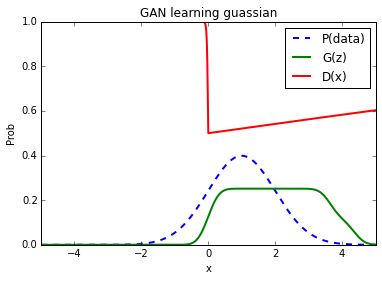

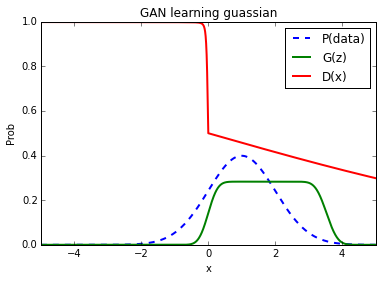

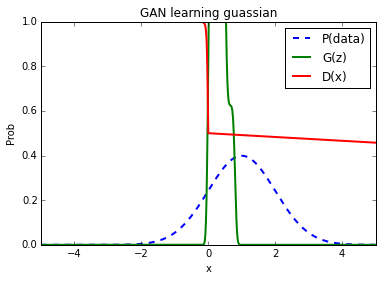

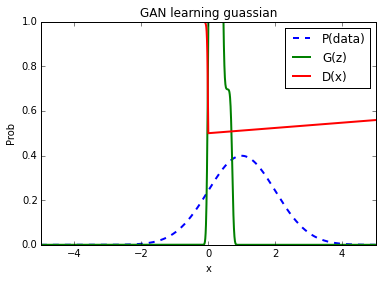

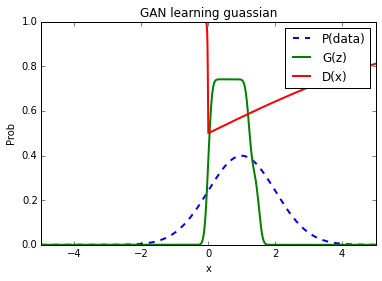

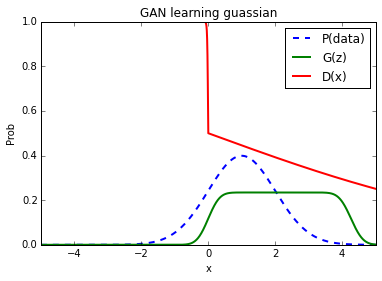

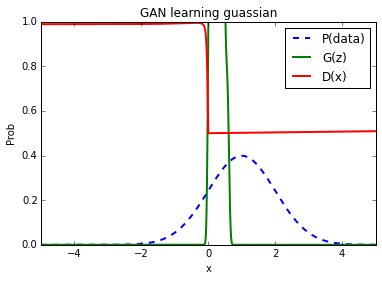

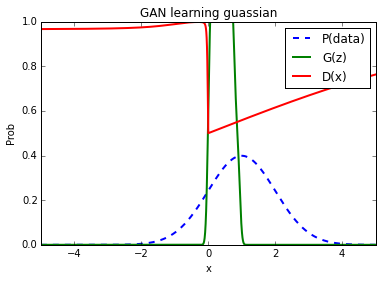

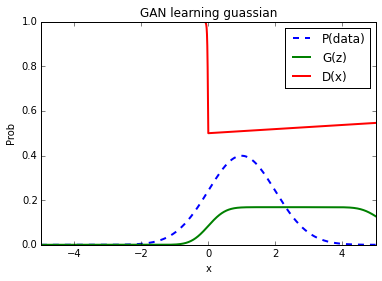

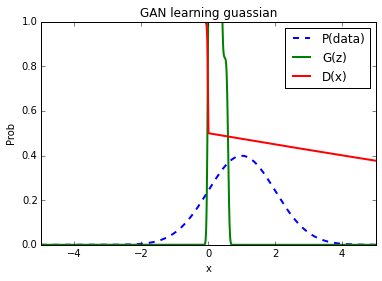

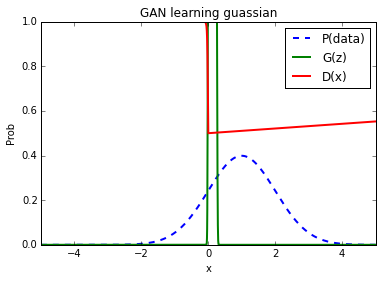

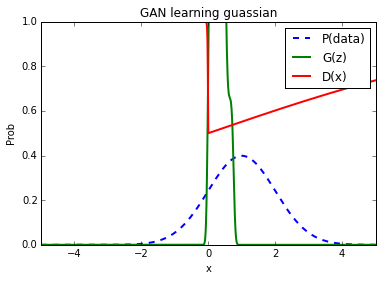

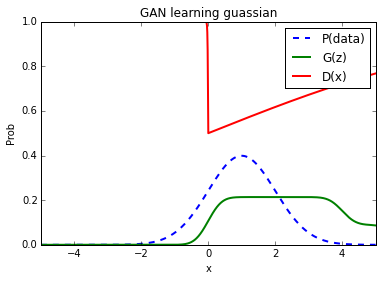

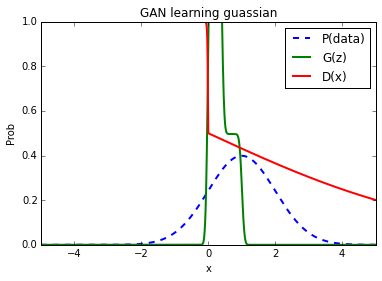

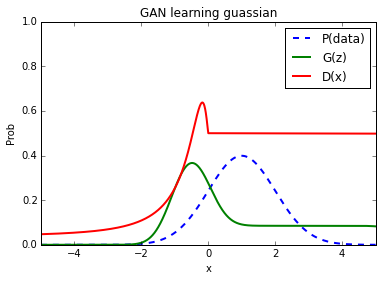

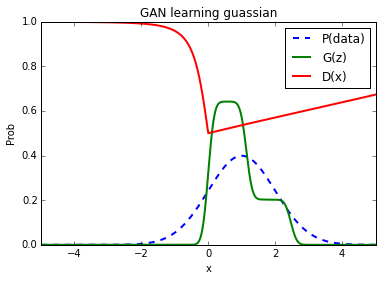

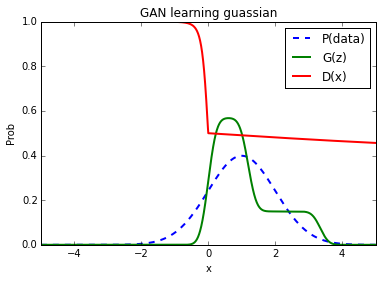

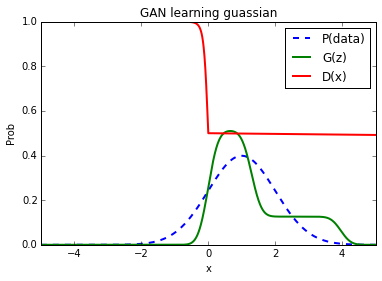

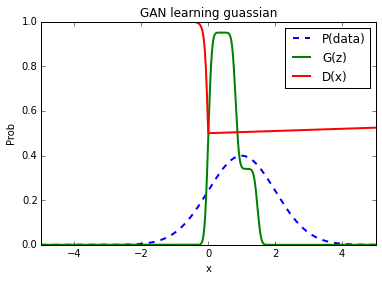

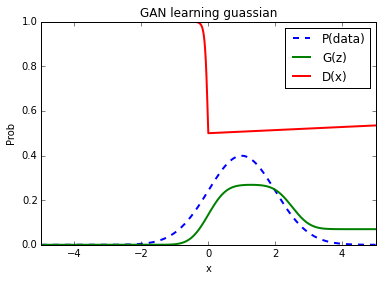

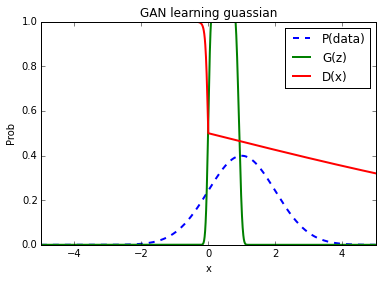

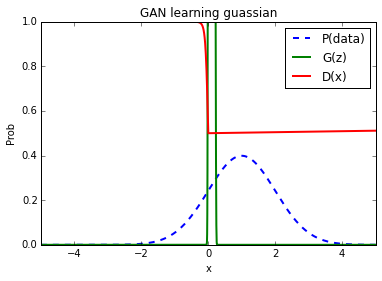

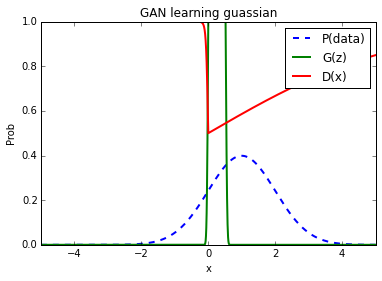

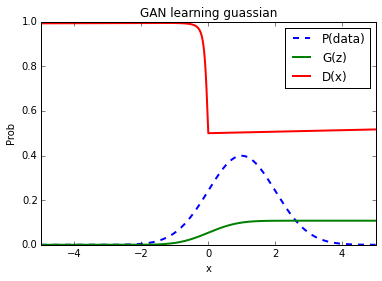

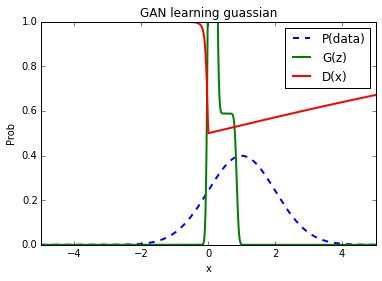

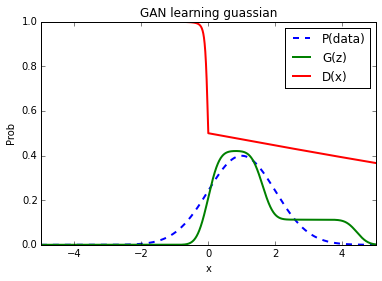

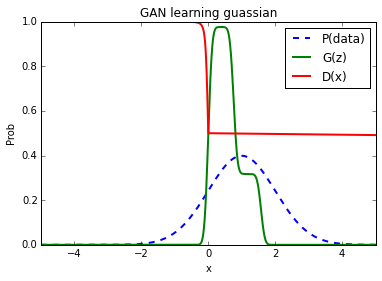

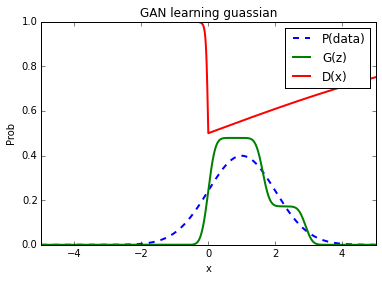

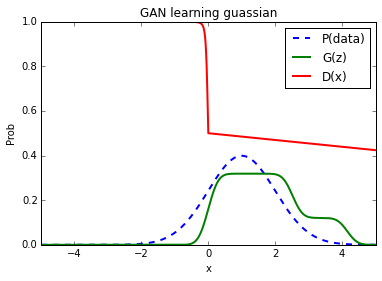

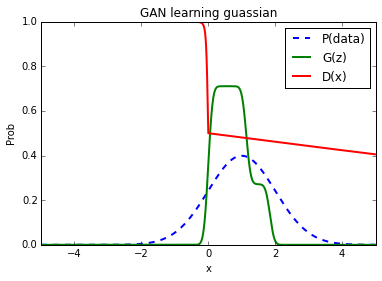

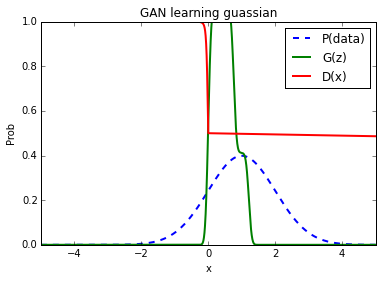

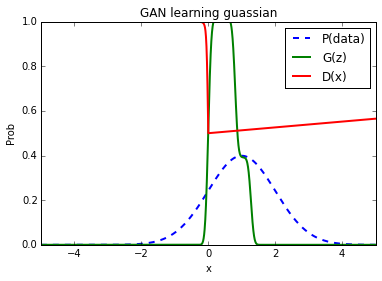

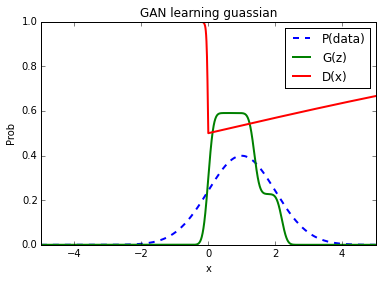

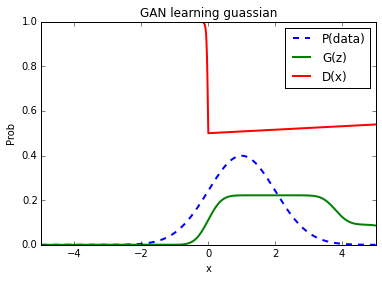

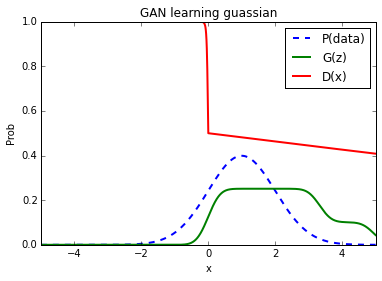

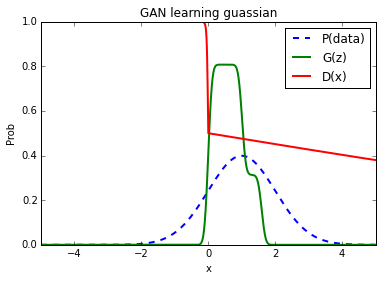

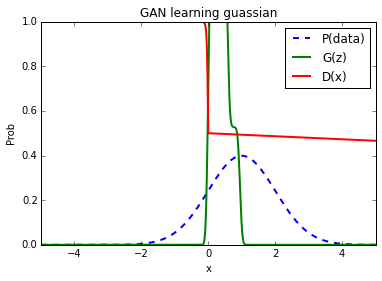

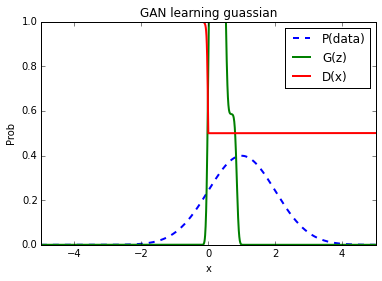

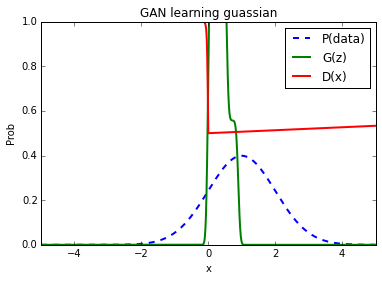

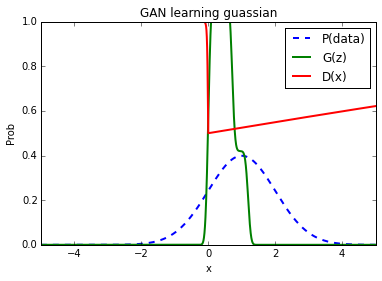

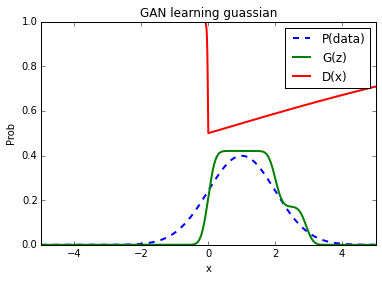

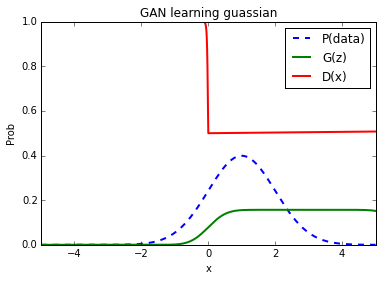

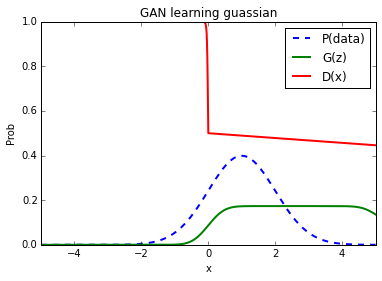

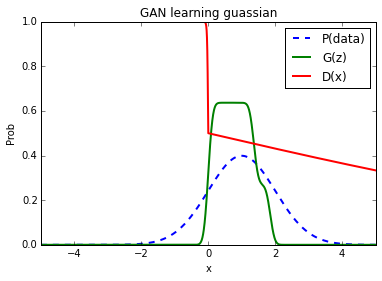

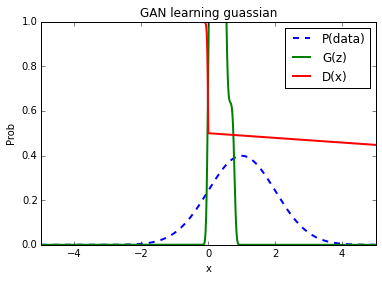

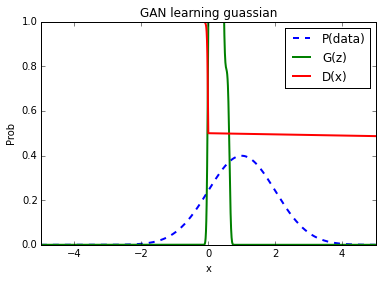

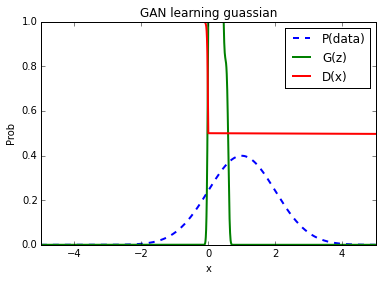

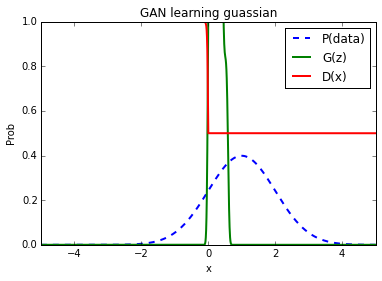

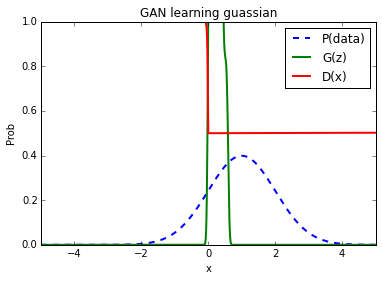

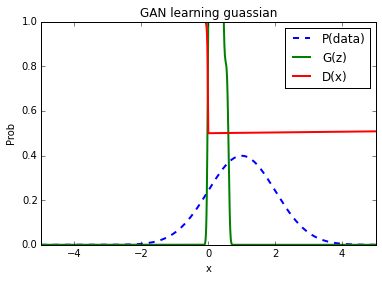

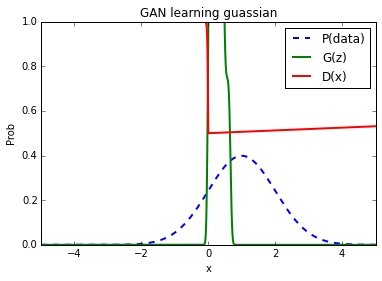

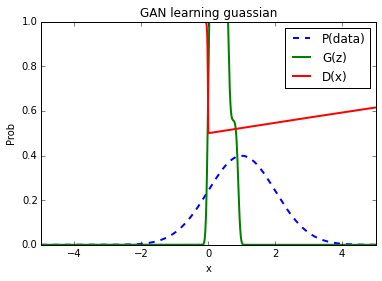

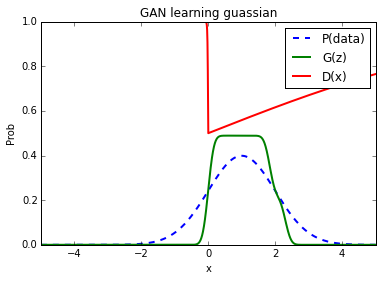

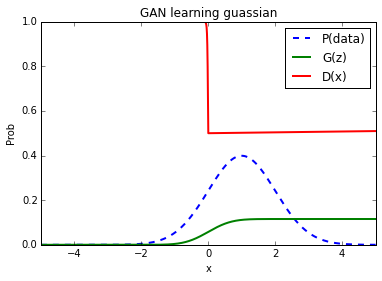

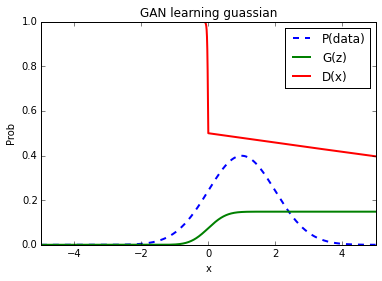

In [6]:

# ------------------------------------------------------- initialize both networks ----------------------------------------------------------
# we initialize the parameters with location = 0 and scale = 0.02.
gw = Normal(scale=0.02)((1, nh))
gw2 = Normal(scale=0.02)((nh, nh))
gy = Normal(scale=0.02)((nh, 1)) 
dw = Normal(scale=0.02)((1, nh))
dw2 = Normal(scale=0.02)((nh, nh))
dy = Normal(scale=0.02)((nh, 1))

# ---------------------------------------------------------- set the parameters --------------------------------------------------------------
g_params = [gw, gw2, gy]
d_params = [dw, dw2, dy]

# -------------------------------------------------------- get the matrix transpose ----------------------------------------------------------
Z = T.matrix()
X = T.matrix()

# -------------------------------------------------- build the generator from the transpose --------------------------------------------------
gen = g(Z, *g_params)

# ------------------------------------------------ get both the real and the generated samples -----------------------------------------------
p_real = d(X, *d_params)
p_gen = d(gen, *d_params)

# -------------------------------- get the cost functions from both the real, generated, and discriminator functions -------------------------
# -------------------------------------------------------- how far is p_real from 1 ----------------------------------------------------------
d_cost_real = bce(p_real, T.ones(p_real.shape)).mean()
# --------------------------------------------------------- how far is p_gen from 0 ----------------------------------------------------------
d_cost_gen = bce(p_gen, T.zeros(p_gen.shape)).mean()
# --------------------------------------------------------- how far is p_gen from 1 ----------------------------------------------------------
g_cost_d = bce(p_gen, T.ones(p_gen.shape)).mean()

# ------------------------------------------ get the cost functions from the discriminator function ------------------------------------------
d_cost = d_cost_real + d_cost_gen
g_cost = g_cost_d

# ------------------------------------------------------ create the grand cost function ------------------------------------------------------
cost = [g_cost, d_cost]

#update the weights using the 'adam' method https://arxiv.org/pdf/1412.6980
lr = 0.001
lrt = sharedX(lr)
d_updater = Adam(lr=lrt)
g_updater = Adam(lr=lrt)

d_updates = d_updater(d_params, d_cost)
g_updates = g_updater(g_params, g_cost)

#get the final variables for both networks, cost, and score (to keep track of things)
_train_g = theano.function([X, Z], cost, updates=g_updates)
_train_d = theano.function([X, Z], cost, updates=d_updates)
#_train_both = theano.function([X, Z], cost, updates=updates)
_gen = theano.function([Z], gen)
_score = theano.function([X], p_real)
_cost = theano.function([X, Z], cost)

#create the graph figure
fig = plt.figure()

#plotting function - plot both curves (for G and D)
def vis(i):
    s = 1.
    u = 0.
    zs = np.linspace(-1, 1, 2000).astype('float32')
    xs = np.linspace(-5, 5, 2000).astype('float32')
    ps = gaussian_likelihood(xs, 1.)

    gs = _gen(zs.reshape(-1, 1)).flatten()
    preal = _score(xs.reshape(-1, 1)).flatten()
    # estimate a gaussian non-parametric distribution using the generator values
    kde = gaussian_kde(gs)

    plt.clf()
    plt.plot(xs, ps, '--', lw=2)
    plt.plot(xs, kde(xs), lw=2)
    plt.plot(xs, preal, lw=2)
    plt.xlim([-5., 5.])
    plt.ylim([0., 1.])
    plt.ylabel('Prob')
    plt.xlabel('x')
    plt.legend(['P(data)', 'G(z)', 'D(x)'])
    plt.title('GAN learning guassian')
    fig.canvas.draw()
    plt.show(block=False)
    show()

#Train both networks
for i in range(10001):
    # get the uniform distribution of both networks
    # The zmb (z mini batch) is randomly drawn from a uniform distribution
    zmb = np.random.uniform(-1, 1, size=(batch_size, 1)).astype('float32')
    # The xmb are randomly drawn from a gaussian distribution, these are actually our target values that we want our generator to learn
    # to compute from the uniformly drawn inputs.
    xmb = np.random.normal(1., 1, size=(batch_size, 1)).astype('float32')
    # Train the discriminator for x times and then the generator once
    if i % 2 == 0:
        print i
        _train_g(xmb, zmb)
    else:
        _train_d(xmb, zmb)
    if i % 100 == 0:
        print i
        vis(i)
    lrt.set_value(floatX(lrt.get_value()*0.9999))
